In [1]:
import pandas as pd
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/Users/youjunglee/머러플_P4-2/proj4-2/data/kospi_yahoo_AB_full_features_with_macro.csv')
sub = pd.read_excel('/Users/youjunglee/머러플_P4-2/proj4-2/data/뉴스심리지수.xlsx') 

In [3]:
original = pd.read_csv('/Users/youjunglee/머러플_P4-2/proj4-2/data/kospi_yahoo_AB_full_features_with_macro.csv')

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
sub['date'] = pd.to_datetime(sub['date']) 

In [6]:
sub

,date,news_emotion
0,2005-01-01,95.60
1,2005-01-02,97.10
2,2005-01-03,101.07
3,2005-01-04,101.52
4,2005-01-05,102.00
...,...,...
7634,2025-11-26,115.36
7635,2025-11-27,114.34
7636,2025-11-28,114.64
7637,2025-11-29,112.99


In [7]:
merged_df = pd.merge(df, sub, on='date', how='left')

In [8]:
df = merged_df.copy()

In [9]:
H = 1  # 하루 거래일 forward
df = df.sort_values("date").reset_index(drop=True)
df["forward_return"] = df["close"].shift(-H) / df["close"] - 1

In [10]:
def compute_market_forward_excess_returns(df, date_col="date", price_col="close",
                                          horizon=1, rolling_years=5, is_crypto=False):

    df = df.sort_values(date_col).reset_index(drop=True).copy()

    df["forward_return"] = df[price_col].shift(-horizon) / df[price_col] - 1

    if is_crypto:
        window = 365 * rolling_years
    else:
        window = 252 * rolling_years

    df["rolling_5yr_mean"] = (
        df["forward_return"]
        .rolling(window=window, min_periods=200)  # min_periods는 자유 조절 가능
        .mean()
    )

    df["market_forward_excess_returns"] = (
        df["forward_return"] - df["rolling_5yr_mean"]
    )

    if "is_train" not in df.columns:
        raise ValueError("df에 train/test 구분용 'is_train' 컬럼을 넣어주세요.")

    train = df[df["is_train"]].copy()
    test  = df[~df["is_train"]].copy()

    y_train = train["market_forward_excess_returns"].dropna()

    median = y_train.median()
    mad = (y_train - median).abs().median()

    k = 4  # 교수님 말씀 기준
    lower = median - k * mad
    upper = median + k * mad

    df["market_forward_excess_returns"] = df["market_forward_excess_returns"].clip(lower, upper)

    return df, {"median": median, "mad": mad, "lower": lower, "upper": upper}


In [11]:
df["is_train"] = df["date"] < "2020-01-01"  # 예시 split

df_processed, mad_info = compute_market_forward_excess_returns(
    df,
    date_col="date",
    price_col="close",
    horizon=1,
    rolling_years=5,
    is_crypto=False  # 크립토면 True
)

In [12]:
df_processed.isnull().sum()

date                                0
close                               0
high                                0
low                                 0
open                                0
volume                              0
ret_1d                              1
ret_5d                              5
ret_22d                            22
ma_5                                4
ma_20                              19
ma_60                              59
ma_120                            119
vol_22d                            22
rsi_14                             14
macd                                0
macd_signal                         0
macd_hist                           0
atr_14                             13
bb_middle                          19
bb_upper                           19
bb_lower                           19
momentum_10                        10
momentum_20                        20
momentum_60                        60
drawdown_60                        59
max_drawdown

In [13]:
df_processed

,date,close,high,low,open,volume,ret_1d,ret_5d,ret_22d,ma_5,...,drawdown_60,max_drawdown_60,usdkrw,gold_price,vix,news_emotion,forward_return,is_train,rolling_5yr_mean,market_forward_excess_returns
0,2000-01-04,1059.040039,1066.180054,1016.590027,1028.329956,195900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.010000,NaN,-0.068675,True,NaN,NaN
1,2000-01-05,986.309998,1026.520020,984.049988,1006.869995,257700,-0.068675,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.410000,NaN,-0.025874,True,NaN,NaN
2,2000-01-06,960.789978,1014.900024,953.500000,1013.950012,203500,-0.025874,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.730000,NaN,-0.012635,True,NaN,NaN
3,2000-01-07,948.650024,970.159973,930.840027,949.169983,215700,-0.012635,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,21.719999,NaN,0.040679,True,NaN,NaN
4,2000-01-10,987.239990,994.940002,974.820007,979.669983,240200,0.040679,NaN,NaN,988.406006,...,NaN,NaN,NaN,NaN,21.709999,NaN,-0.005986,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,2024-12-23,2442.010010,2446.969971,2413.620117,2423.360107,428200,0.015748,-0.018867,-0.015569,2444.665967,...,-0.085927,-0.116407,1445.420044,2612.300049,16.780001,96.66,-0.000610,False,0.000190,-0.000800
6157,2024-12-24,2440.520020,2452.850098,2432.419922,2450.550049,386800,-0.000610,-0.006631,-0.024276,2441.407959,...,-0.078973,-0.116407,1442.699951,2620.000000,14.270000,95.81,-0.004446,False,0.000180,-0.004626
6158,2024-12-26,2429.669922,2449.520020,2428.820068,2449.520020,322800,-0.004446,-0.022041,-0.041301,2430.455957,...,-0.077381,-0.116407,1457.609985,2638.800049,14.730000,94.08,-0.010248,False,0.000179,-0.010427
6159,2024-12-27,2404.770020,2423.860107,2388.330078,2419.459961,311300,-0.010248,-0.012792,-0.045863,2424.223975,...,-0.086837,-0.116407,1466.989990,2617.199951,15.950000,91.17,-0.002196,False,0.000171,-0.002367


In [14]:
df_processed.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'ret_1d', 'ret_5d',
       'ret_22d', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'vol_22d', 'rsi_14',
       'macd', 'macd_signal', 'macd_hist', 'atr_14', 'bb_middle', 'bb_upper',
       'bb_lower', 'momentum_10', 'momentum_20', 'momentum_60', 'drawdown_60',
       'max_drawdown_60', 'usdkrw', 'gold_price', 'vix', 'news_emotion',
       'forward_return', 'is_train', 'rolling_5yr_mean',
       'market_forward_excess_returns'],
      dtype='object')

In [15]:
# 삭제 전 요약
print("Null counts by column before drop:")
print(df_processed.isnull().sum())

print(f"\nRows before: {len(df_processed)}")

df_processed = df_processed.dropna().reset_index(drop=True)

print(f"\nRows after: {len(df_processed)}")
print("\nNull counts by column after drop:")
print(df_processed.isnull().sum())

Null counts by column before drop:
date                                0
close                               0
high                                0
low                                 0
open                                0
volume                              0
ret_1d                              1
ret_5d                              5
ret_22d                            22
ma_5                                4
ma_20                              19
ma_60                              59
ma_120                            119
vol_22d                            22
rsi_14                             14
macd                                0
macd_signal                         0
macd_hist                           0
atr_14                             13
bb_middle                          19
bb_upper                           19
bb_lower                           19
momentum_10                        10
momentum_20                        20
momentum_60                        60
drawdown_60    

In [16]:
df_processed

,date,close,high,low,open,volume,ret_1d,ret_5d,ret_22d,ma_5,...,drawdown_60,max_drawdown_60,usdkrw,gold_price,vix,news_emotion,forward_return,is_train,rolling_5yr_mean,market_forward_excess_returns
0,2005-01-03,893.710022,897.590027,890.929993,896.000000,252600,-0.002467,0.015672,0.019286,885.862000,...,-0.002467,-0.089368,1027.300049,428.700012,14.080000,101.07,-0.007620,True,0.000074,-0.007694
1,2005-01-04,886.900024,895.400024,884.940002,890.559998,331600,-0.007620,0.011312,0.003167,887.846008,...,-0.010068,-0.089368,1028.699951,428.500000,13.980000,101.52,-0.001928,True,0.000072,-0.002000
2,2005-01-05,885.190002,885.200012,873.179993,874.919983,343100,-0.001928,0.007696,0.002991,889.198010,...,-0.011976,-0.089368,1035.800049,426.600006,14.090000,102.00,-0.015714,True,0.000059,-0.015773
3,2005-01-06,871.280029,886.309998,871.280029,878.229981,394700,-0.015714,-0.014690,0.000609,886.600012,...,-0.027502,-0.089368,1048.400024,421.000000,13.580000,101.45,-0.000505,True,0.000059,-0.000564
4,2005-01-07,870.840027,878.890015,866.719971,876.359985,294800,-0.000505,-0.027994,0.011346,881.584021,...,-0.027994,-0.089368,1045.099976,418.899994,13.490000,102.14,0.003835,True,0.000062,0.003773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,2024-12-20,2404.149902,2430.689941,2389.860107,2429.629883,617800,-0.013046,-0.036204,-0.031479,2454.057959,...,-0.100099,-0.116407,1437.449951,2628.699951,18.360001,91.19,0.015748,False,0.000186,0.015562
4929,2024-12-23,2442.010010,2446.969971,2413.620117,2423.360107,428200,0.015748,-0.018867,-0.015569,2444.665967,...,-0.085927,-0.116407,1445.420044,2612.300049,16.780001,96.66,-0.000610,False,0.000190,-0.000800
4930,2024-12-24,2440.520020,2452.850098,2432.419922,2450.550049,386800,-0.000610,-0.006631,-0.024276,2441.407959,...,-0.078973,-0.116407,1442.699951,2620.000000,14.270000,95.81,-0.004446,False,0.000180,-0.004626
4931,2024-12-26,2429.669922,2449.520020,2428.820068,2449.520020,322800,-0.004446,-0.022041,-0.041301,2430.455957,...,-0.077381,-0.116407,1457.609985,2638.800049,14.730000,94.08,-0.010248,False,0.000179,-0.010427


In [17]:
# drop rows where columns A, B, C are null — works whether df_processed or df is present
target_name = "df_processed" if "df_processed" in globals() else "df"
df_target = globals().get(target_name)

cols = ["usdkrw", "gold_price", "rolling_5yr_mean", "market_forward_excess_returns"]
cols_present = [c for c in cols if c in df_target.columns]

if not cols_present:
  print(f"No matching columns found in {target_name}: {cols}")
else:
  before = len(df_target)
  df_target = df_target.dropna(subset=cols_present).reset_index(drop=True)
  after = len(df_target)
  print(f"Dropped {before-after} rows where any of {cols_present} were null. Rows before: {before}, after: {after}")

# write back to the original variable
if target_name == "df_processed":
  df_processed = df_target
else:
  df = df_target

Dropped 0 rows where any of ['usdkrw', 'gold_price', 'rolling_5yr_mean', 'market_forward_excess_returns'] were null. Rows before: 4933, after: 4933


In [18]:
df_target.isnull().sum()

date                             0
close                            0
high                             0
low                              0
open                             0
volume                           0
ret_1d                           0
ret_5d                           0
ret_22d                          0
ma_5                             0
ma_20                            0
ma_60                            0
ma_120                           0
vol_22d                          0
rsi_14                           0
macd                             0
macd_signal                      0
macd_hist                        0
atr_14                           0
bb_middle                        0
bb_upper                         0
bb_lower                         0
momentum_10                      0
momentum_20                      0
momentum_60                      0
drawdown_60                      0
max_drawdown_60                  0
usdkrw                           0
gold_price          

In [19]:
df_target = df_target.drop('is_train', axis=1)

## EDA 및 통계검정

### 0. 세팅 및 데이터 로드

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

df = df_target.copy()

# date 파싱 & 정렬
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

df.head()


,date,close,high,low,open,volume,ret_1d,ret_5d,ret_22d,ma_5,...,momentum_60,drawdown_60,max_drawdown_60,usdkrw,gold_price,vix,news_emotion,forward_return,rolling_5yr_mean,market_forward_excess_returns
0,2005-01-03,893.710022,897.590027,890.929993,896.000000,252600,-0.002467,0.015672,0.019286,885.862000,...,12.330017,-0.002467,-0.089368,1027.300049,428.700012,14.08,101.07,-0.007620,0.000074,-0.007694
1,2005-01-04,886.900024,895.400024,884.940002,890.559998,331600,-0.007620,0.011312,0.003167,887.846008,...,5.790039,-0.010068,-0.089368,1028.699951,428.500000,13.98,101.52,-0.001928,0.000072,-0.002000
2,2005-01-05,885.190002,885.200012,873.179993,874.919983,343100,-0.001928,0.007696,0.002991,889.198010,...,27.099976,-0.011976,-0.089368,1035.800049,426.600006,14.09,102.00,-0.015714,0.000059,-0.015773
3,2005-01-06,871.280029,886.309998,871.280029,878.229981,394700,-0.015714,-0.014690,0.000609,886.600012,...,15.100037,-0.027502,-0.089368,1048.400024,421.000000,13.58,101.45,-0.000505,0.000059,-0.000564
4,2005-01-07,870.840027,878.890015,866.719971,876.359985,294800,-0.000505,-0.027994,0.011346,881.584021,...,24.210022,-0.027994,-0.089368,1045.099976,418.899994,13.49,102.14,0.003835,0.000062,0.003773


In [21]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)

display(df.describe().T)

print("\n결측치 개수:")
print(df.isna().sum())

Shape: (4933, 34)

Dtypes:
 date                             datetime64[ns]
close                                   float64
high                                    float64
low                                     float64
open                                    float64
volume                                    int64
ret_1d                                  float64
ret_5d                                  float64
ret_22d                                 float64
ma_5                                    float64
ma_20                                   float64
ma_60                                   float64
ma_120                                  float64
vol_22d                                 float64
rsi_14                                  float64
macd                                    float64
macd_signal                             float64
macd_hist                               float64
atr_14                                  float64
bb_middle                               float64
bb_upper    

,count,mean,min,25%,50%,75%,max,std
date,4933,2014-12-19 19:47:12.272450816,2005-01-03 00:00:00,2009-12-17 00:00:00,2014-12-10 00:00:00,2019-12-20 00:00:00,2024-12-27 00:00:00,NaN
close,4933.0,2019.635842,870.840027,1755.030029,2001.469971,2355.050049,3305.209961,491.044673
high,4933.0,2031.147462,875.0,1765.810059,2009.670044,2367.840088,3316.080078,492.857509
low,4933.0,2007.204805,866.169983,1740.109985,1991.810059,2340.189941,3295.439941,490.055895
open,4933.0,2020.750933,872.820007,1753.670044,2001.97998,2353.919922,3305.459961,491.604938
volume,4933.0,468899.797284,0.0,317700.0,402400.0,534300.0,3455500.0,251053.596608
ret_1d,4933.0,0.000275,-0.105705,-0.00531,0.00062,0.006558,0.119457,0.01222
ret_5d,4933.0,0.001406,-0.216275,-0.012319,0.003281,0.016732,0.219336,0.027484
ret_22d,4933.0,0.006223,-0.367338,-0.024738,0.007248,0.03877,0.29159,0.056035
ma_5,4933.0,2019.013064,876.124011,1754.571997,2000.055981,2352.826025,3294.837988,491.070674



결측치 개수:
date                             0
close                            0
high                             0
low                              0
open                             0
volume                           0
ret_1d                           0
ret_5d                           0
ret_22d                          0
ma_5                             0
ma_20                            0
ma_60                            0
ma_120                           0
vol_22d                          0
rsi_14                           0
macd                             0
macd_signal                      0
macd_hist                        0
atr_14                           0
bb_middle                        0
bb_upper                         0
bb_lower                         0
momentum_10                      0
momentum_20                      0
momentum_60                      0
drawdown_60                      0
max_drawdown_60                  0
usdkrw                           0
gold_price 

In [22]:
# 타깃: 일간 초과수익률
target_col = "market_forward_excess_returns"

benchmark_col = "forward_return"

In [23]:
y = df[target_col]

## 4. 타겟 EDA


[ADF Test]
ADF Statistic: -69.10242055034375
p-value: 0.0

[Jarque-Bera Test]
JB Stat: 32.418780532323176
p-value: 9.127487616210005e-08

[Shapiro-Wilk Test] (sample size = 4933 )
Stat: 0.9848882670813586
p-value: 1.4377701856058473e-22


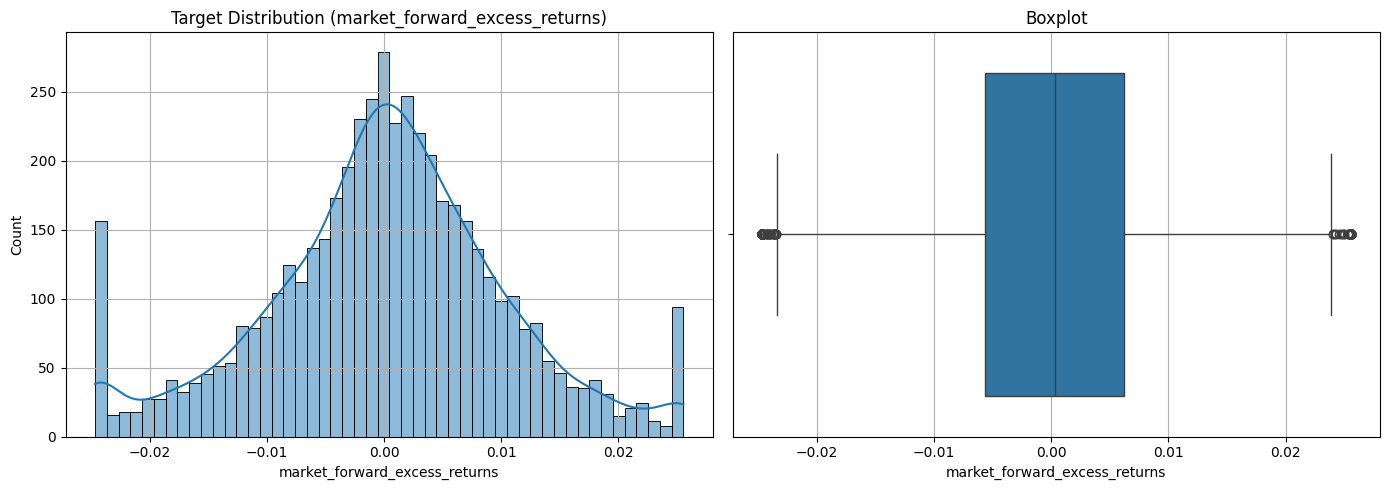

In [24]:
# ADF (정상성)
adf_result = adfuller(y.dropna())
print("\n[ADF Test]")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Jarque-Bera (꼬리/첨도)
jb_stat, jb_pvalue, _, _ = jarque_bera(y)
print("\n[Jarque-Bera Test]")
print("JB Stat:", jb_stat)
print("p-value:", jb_pvalue)

# Shapiro-Wilk (정규성) - 샘플 너무 크면 느릴 수 있어서 앞 5000개만
sample_for_shapiro = y.sample(min(5000, len(y)), random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(sample_for_shapiro)
print("\n[Shapiro-Wilk Test] (sample size =", len(sample_for_shapiro), ")")
print("Stat:", shapiro_stat)
print("p-value:", shapiro_p)

# 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(y, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Target Distribution (market_forward_excess_returns)")

sns.boxplot(x=y, ax=axes[1])
axes[1].set_title("Boxplot")

plt.tight_layout()
plt.show()

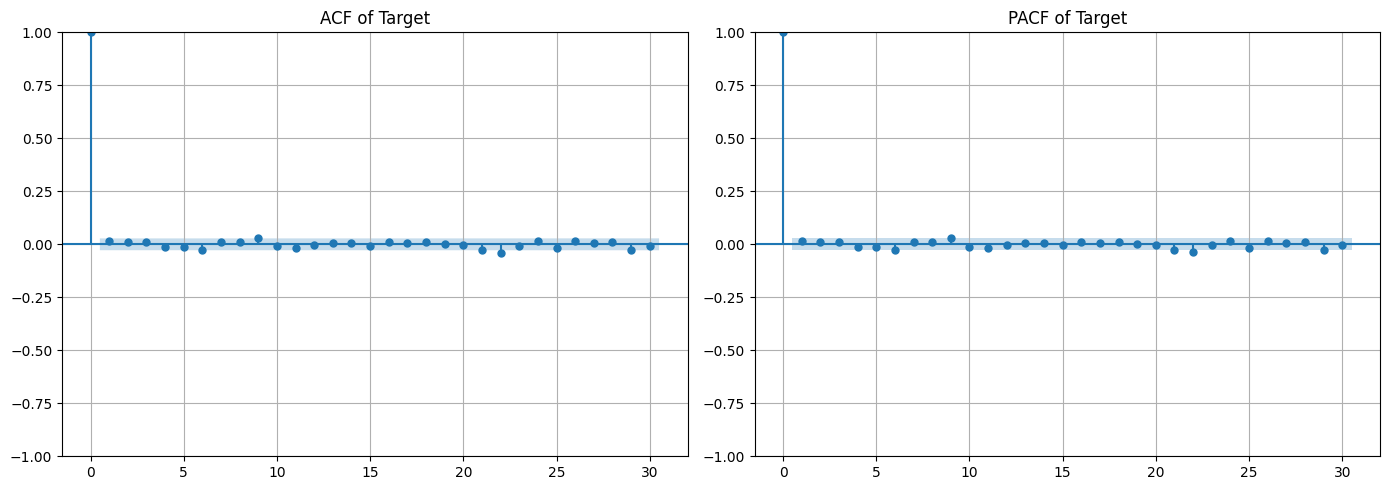

In [25]:
#ACF/PACF 자기상관 구조
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(y, lags=30, ax=axes[0])
axes[0].set_title("ACF of Target")

plot_pacf(y, lags=30, ax=axes[1])
axes[1].set_title("PACF of Target")

plt.tight_layout()
plt.show()

In [26]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek  # 0=월, 6=일

# 월 내에서 몇 번째 주인지 (1~5)
df["week_of_month"] = ((df["day"] - 1) // 7 + 1).astype(int)

# 월초/중순/말 파트 (월급 타이밍 가설용)
def month_part(day):
    if day <= 10:
        return "early"   # 월초
    elif day <= 20:
        return "mid"     # 중순
    else:
        return "late"    # 월말

df["month_part"] = df["day"].apply(month_part)

df[["date", "year", "month", "day", "dayofweek", "week_of_month", "month_part"]].head(15)

,date,year,month,day,dayofweek,week_of_month,month_part
0,2005-01-03,2005,1,3,0,1,early
1,2005-01-04,2005,1,4,1,1,early
2,2005-01-05,2005,1,5,2,1,early
3,2005-01-06,2005,1,6,3,1,early
4,2005-01-07,2005,1,7,4,1,early
5,2005-01-10,2005,1,10,0,2,early
6,2005-01-11,2005,1,11,1,2,mid
7,2005-01-12,2005,1,12,2,2,mid
8,2005-01-13,2005,1,13,3,2,mid
9,2005-01-14,2005,1,14,4,2,mid


월별 타깃 통계:


,mean,std,count
month,,,
1,-0.000273,0.011118,414
2,-0.000208,0.010801,375
3,0.000729,0.010283,427
4,0.000733,0.008976,420
5,-0.000227,0.009869,396
6,-0.000541,0.010153,410
7,0.000740,0.009359,439
8,-0.000530,0.010667,427
9,0.000021,0.010698,390


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_58241/2591632424.py:21: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


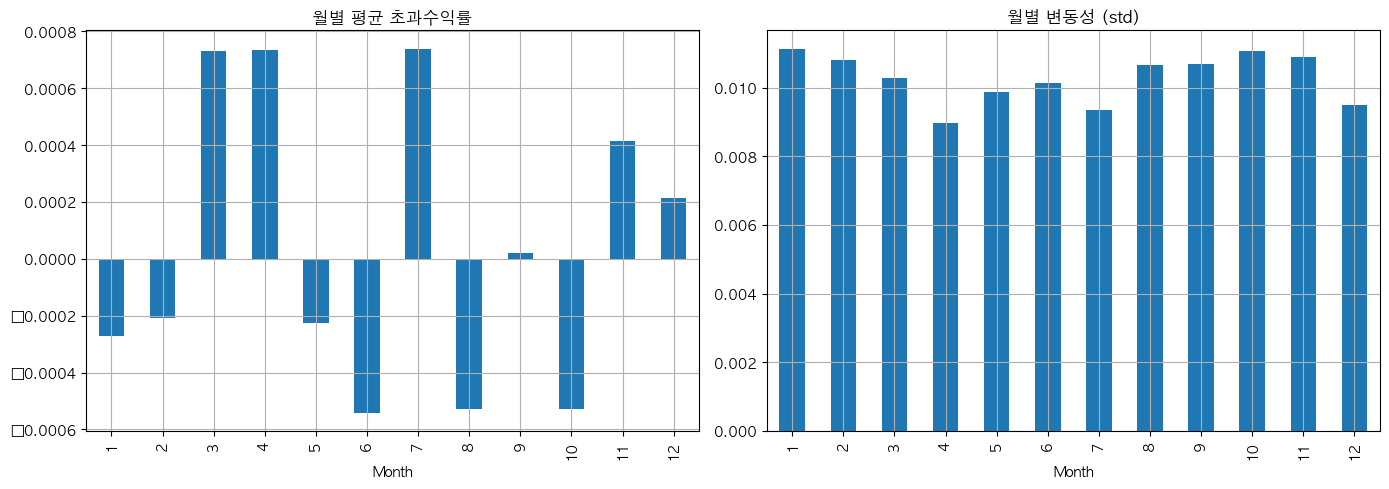

요일별 타깃 통계 (0=월, 4=금):


,mean,std,count
dayofweek,,,
0,0.000247,0.009475,972
1,0.000153,0.010273,992
2,0.000161,0.010579,982
3,-0.000043,0.010456,1000
4,-0.000235,0.010665,987


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


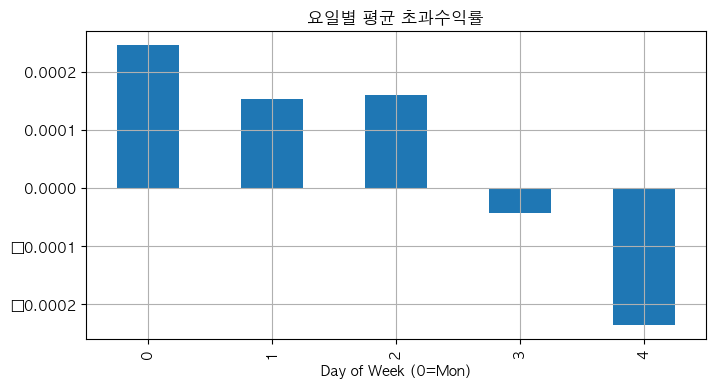

월초/중순/말 타깃 통계:


,mean,std,count
month_part,,,
early,-0.000053,0.010455,1563
mid,-0.000057,0.010202,1655
late,0.000264,0.010250,1715


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


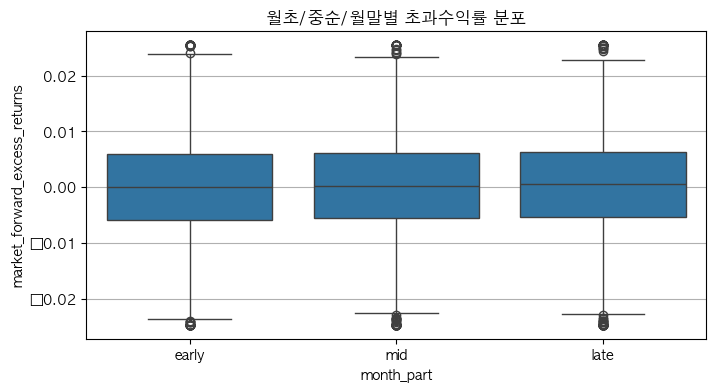

In [27]:
plt.rcParams['font.family'] = 'AppleGothic'

# 월별 평균 & 변동성
monthly_stats = (
    df
    .groupby("month")[target_col]
    .agg(["mean", "std", "count"])
)
print("월별 타깃 통계:")
display(monthly_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
monthly_stats["mean"].plot(kind="bar", ax=axes[0])
axes[0].set_title("월별 평균 초과수익률")
axes[0].set_xlabel("Month")

monthly_stats["std"].plot(kind="bar", ax=axes[1])
axes[1].set_title("월별 변동성 (std)")
axes[1].set_xlabel("Month")

plt.tight_layout()
plt.show()

# 요일별
dow_stats = (
    df
    .groupby("dayofweek")[target_col]
    .agg(["mean", "std", "count"])
)
print("요일별 타깃 통계 (0=월, 4=금):")
display(dow_stats)

plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(8, 4))
dow_stats["mean"].plot(kind="bar")
plt.title("요일별 평균 초과수익률")
plt.xlabel("Day of Week (0=Mon)")
plt.show()

# 월초/중순/월말
mp_stats = (
    df
    .groupby("month_part")[target_col]
    .agg(["mean", "std", "count"])
    .reindex(["early", "mid", "late"])
)
print("월초/중순/말 타깃 통계:")
display(mp_stats)

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="month_part", y=target_col, order=["early", "mid", "late"])
plt.title("월초/중순/월말별 초과수익률 분포")
plt.show()

월 내 주차별 타깃 통계:


,mean,std,count
week_of_month,,,
1,-0.000269,0.010503,1078
2,0.000170,0.010338,1156
3,-0.000170,0.010131,1153
4,-0.000116,0.010133,1161
5,0.001821,0.010466,385


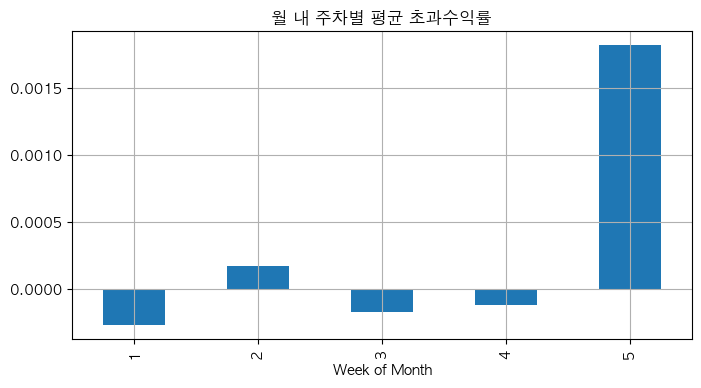

In [28]:
wom_stats = (
    df
    .groupby("week_of_month")[target_col]
    .agg(["mean", "std", "count"])
    .sort_index()
)
print("월 내 주차별 타깃 통계:")
display(wom_stats)

plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(8, 4))
wom_stats["mean"].plot(kind="bar")
plt.title("월 내 주차별 평균 초과수익률")
plt.xlabel("Week of Month")
plt.show()

/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


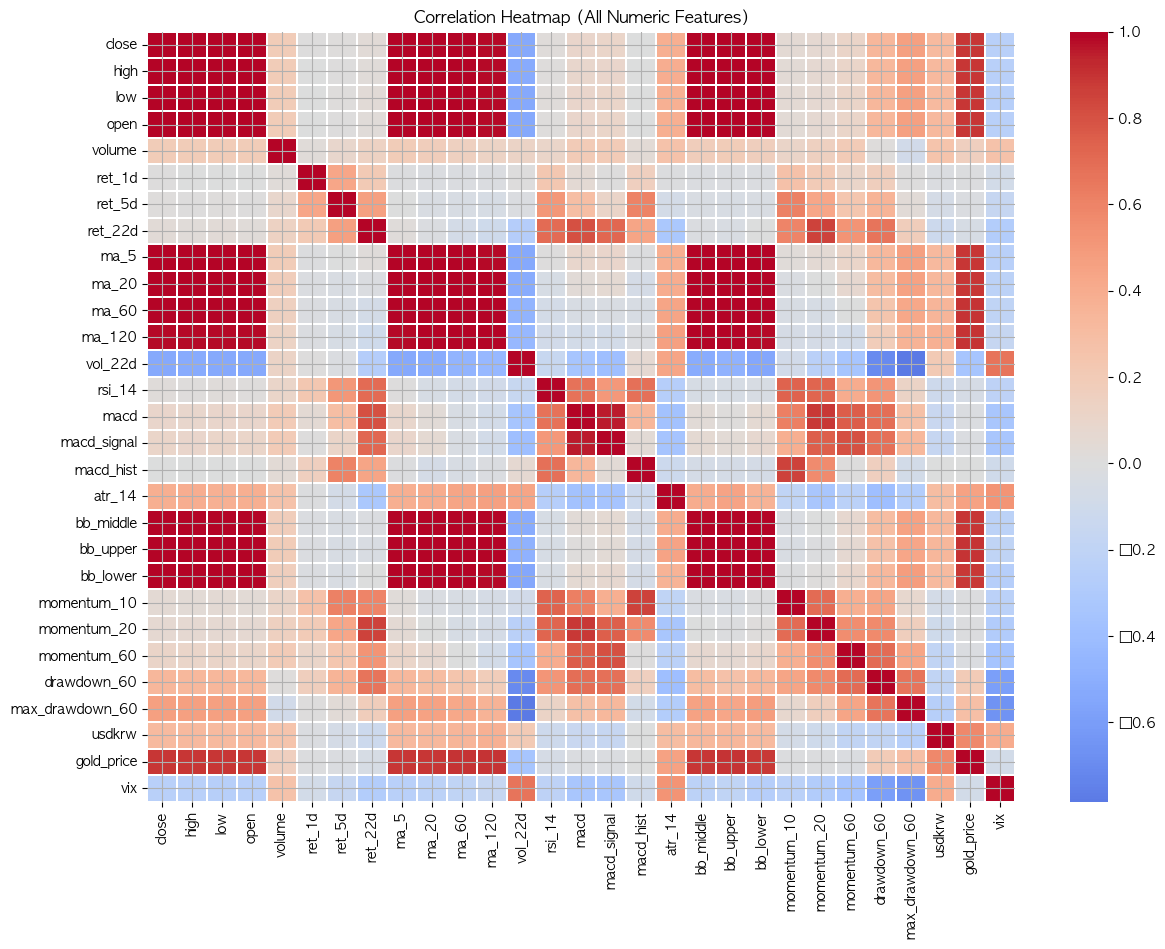

In [29]:
num_cols = original.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr = original[num_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.1)
plt.title("Correlation Heatmap (All Numeric Features)")
plt.show()

In [32]:
df_target.to_csv('../data/kospi_df.csv', encoding='utf-8-sig', index=False)